In [2]:
print("Hello World!")

Hello World!


## 📘 Notebook 1: Data Exploration & Inventory Behavior Analysis


This notebook sets the stage:

- Understand expiry patterns

- Quantify the problem (losses, markdowns, sell-through)

- Identify high-risk categories/stores

- Prep for modeling

# ✅ Notebook Structure


### 📌 1. Business Context & Objective
Include a markdown cell:

- Problem: FrischMarkt loses € annually to expired inventory.

- Goal: Minimize expiry losses through better markdown timing, demand forecasting, and proactive inventory management.

- This Notebook: Initial data exploration to understand expiry patterns and prep for prediction modeling.

## 📥 2. Load Data


In [3]:
import pandas as pd

inventory = pd.read_csv(r"C:\Desktop\Expiry Loss Minimization Project\frischmarkt_data\inventory_daily.csv", parse_dates=["date", "expiry_date", "markdown_date"])
products = pd.read_csv(r"C:\Desktop\Expiry Loss Minimization Project\frischmarkt_data\products_master.csv")
stores = pd.read_csv(r"C:\Desktop\Expiry Loss Minimization Project\frischmarkt_data\stores_master.csv")
external = pd.read_csv(r"C:\Desktop\Expiry Loss Minimization Project\frischmarkt_data\external_factors.csv", parse_dates=["date"])


## 🔍 3. Data Overview





In [5]:
inventory.info()
inventory.describe()
inventory.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65832 entries, 0 to 65831
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 65832 non-null  datetime64[ns]
 1   store_id             65832 non-null  object        
 2   product_id           65832 non-null  object        
 3   beginning_inventory  65832 non-null  int64         
 4   received_inventory   65832 non-null  int64         
 5   expiry_date          22722 non-null  datetime64[ns]
 6   units_sold           65832 non-null  int64         
 7   units_expired        65832 non-null  int64         
 8   units_marked_down    65832 non-null  int64         
 9   markdown_price       5285 non-null   float64       
 10  markdown_date        5285 non-null   datetime64[ns]
 11  current_stock        65832 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(6), object(2)
memory usage: 6.0+ MB


date                       0
store_id                   0
product_id                 0
beginning_inventory        0
received_inventory         0
expiry_date            43110
units_sold                 0
units_expired              0
units_marked_down          0
markdown_price         60547
markdown_date          60547
current_stock              0
dtype: int64

## 📊 4. Expiry Behavior Over Time

* Why it matters: Shows when and where losses peak — key for planning markdown timing and improving stock rotation.



### ✅ A. Weekly Expiry Trend



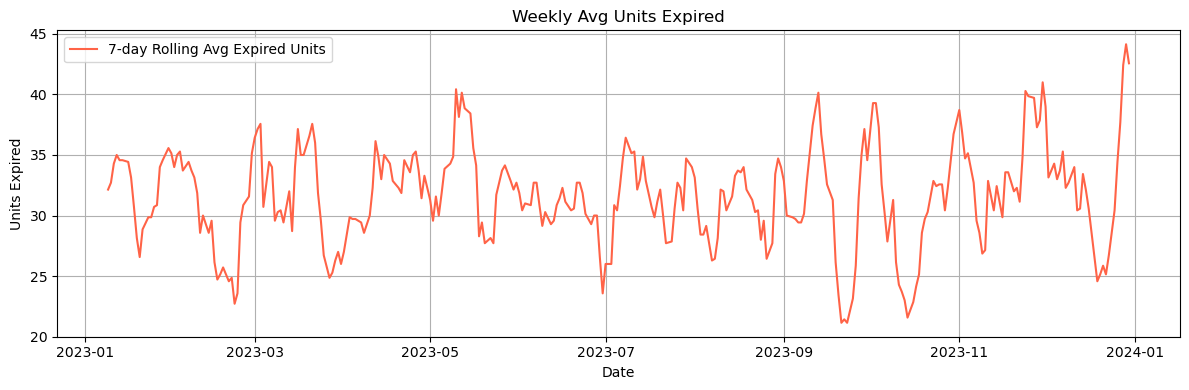

In [ ]:
#Plotted 7-day rolling average of units expired.
import matplotlib.pyplot as plt

expiry_trend = inventory.groupby('date')['units_expired'].sum().rolling(7).mean()

plt.figure(figsize=(12, 4))
plt.plot(expiry_trend, label='7-day Rolling Avg Expired Units', color='tomato')
plt.title("Weekly Avg Units Expired")
plt.ylabel("Units Expired")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ✅ B. Expiry Rate by Store


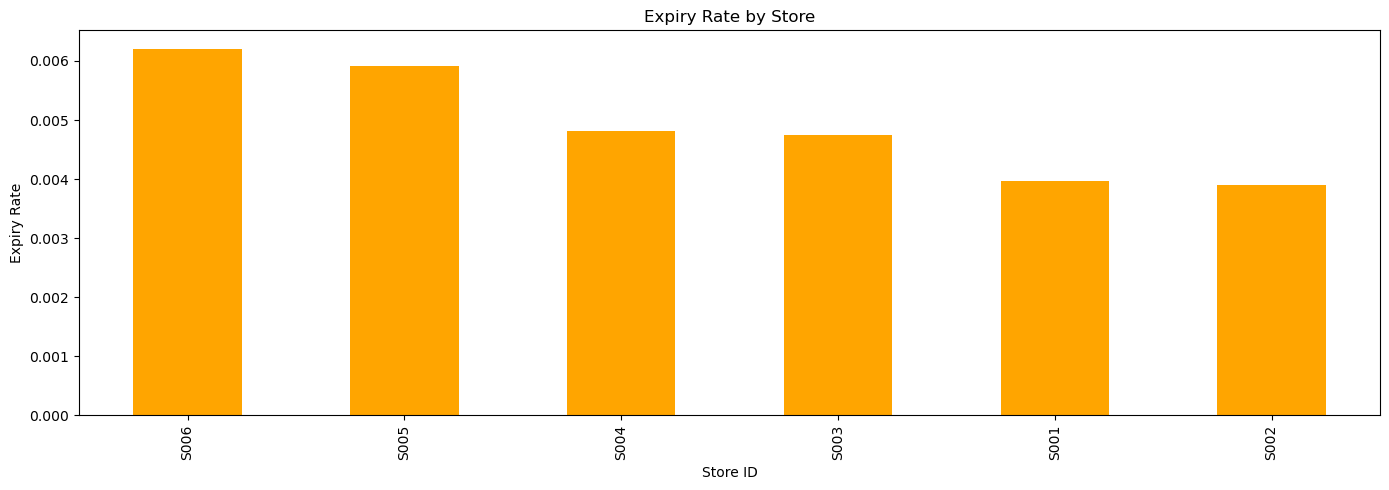

In [8]:
store_expiry = inventory.groupby('store_id')[['units_expired', 'units_sold']].sum()
store_expiry['expiry_rate'] = store_expiry['units_expired'] / (store_expiry['units_sold'] + store_expiry['units_expired'])

store_expiry = store_expiry.sort_values('expiry_rate', ascending=False)

# Plot
store_expiry['expiry_rate'].plot(kind='bar', figsize=(14, 5), title='Expiry Rate by Store', color='orange')
plt.ylabel("Expiry Rate")
plt.xlabel("Store ID")
plt.tight_layout()
plt.show()


### ✅ C. Expiry % by Product Category

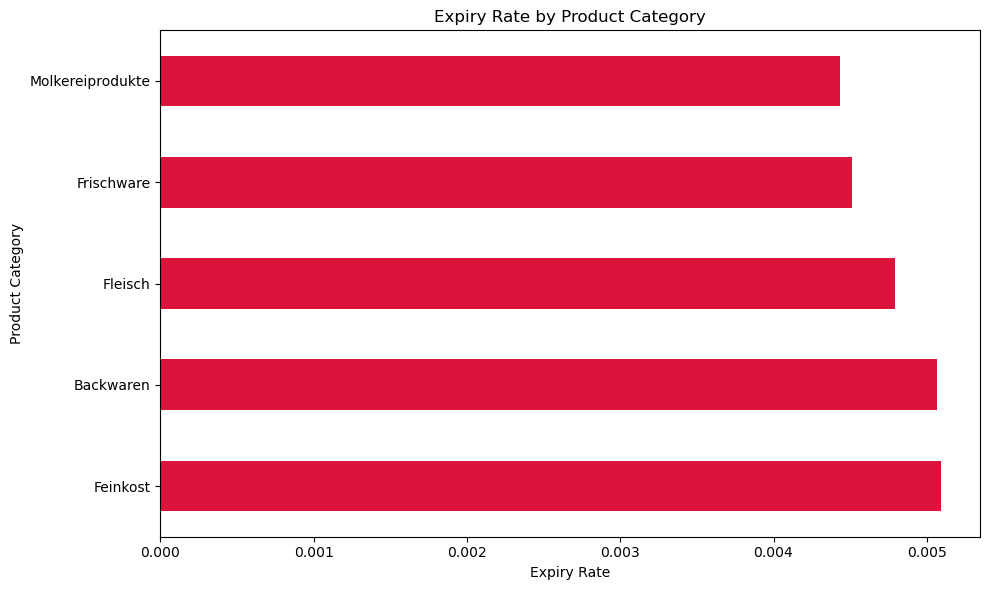

In [10]:
# Load products master
products = pd.read_csv("C:/Desktop/Expiry Loss Minimization Project/frischmarkt_data/products_master.csv")

# Merge product category
inventory_merged = inventory.merge(products[['product_id', 'category']], on='product_id', how='left')

category_expiry = inventory_merged.groupby('category')[['units_expired', 'units_sold']].sum()
category_expiry['expiry_rate'] = category_expiry['units_expired'] / (category_expiry['units_sold'] + category_expiry['units_expired'])

category_expiry = category_expiry.sort_values('expiry_rate', ascending=False)

# Plot
category_expiry['expiry_rate'].plot(kind='barh', figsize=(10, 6), title='Expiry Rate by Product Category', color='crimson')
plt.xlabel("Expiry Rate")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


## 📉 5. Markdown Effectiveness
* Why it matters: Reveals if markdowns are happening too late, or if discounts are insufficient — helps optimize price/timing.

### ✅ A. % of Marked-Down Items Sold Before Expiry (Sell-Through Rate)


In [ ]:
#This metric evaluates markdown success.

# Filter for markdown rows
markdowns = inventory[inventory['units_marked_down'] > 0].copy()

# Sell-through rate = units sold / units marked down
markdowns['sell_through'] = markdowns['units_sold'] / (markdowns['units_marked_down'] + 1e-5)

# Overall effectiveness
overall_sell_through = markdowns['sell_through'].mean()
print(f"✅ Overall Markdown Sell-Through Rate: {overall_sell_through:.2%}")


✅ Overall Markdown Sell-Through Rate: 932.12%


### ✅ B. Markdown Timing vs. Expiry (Days Before Expiry)




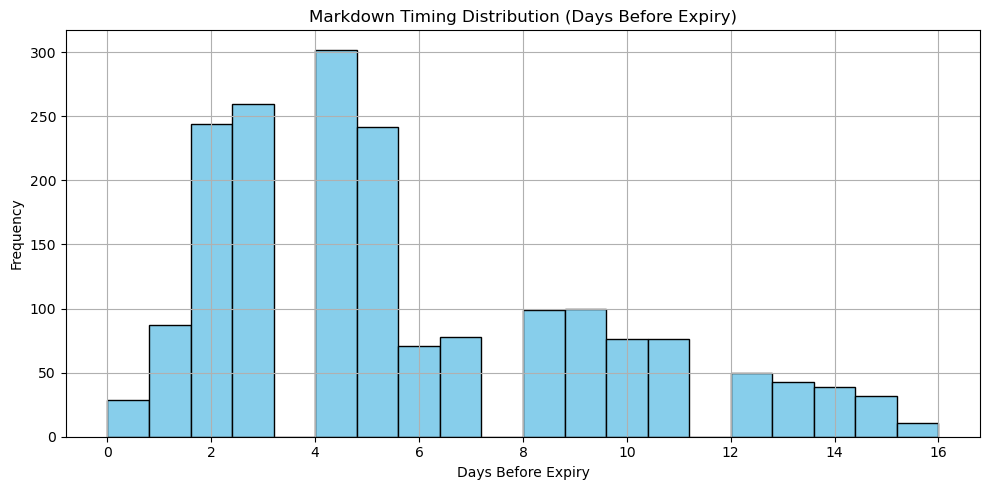

In [12]:
# Calculate days between markdown and expiry
markdowns['days_before_expiry'] = (markdowns['expiry_date'] - markdowns['markdown_date']).dt.days

plt.figure(figsize=(10, 5))
plt.hist(markdowns['days_before_expiry'], bins=20, color='skyblue', edgecolor='black')
plt.title("Markdown Timing Distribution (Days Before Expiry)")
plt.xlabel("Days Before Expiry")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
## Optional: Correlation between days-before-expiry and sell-through:

correlation = markdowns[['days_before_expiry', 'sell_through']].corr().iloc[0, 1]
print(f"📈 Correlation between Markdown Timing and Sell-Through: {correlation:.2f}")


📈 Correlation between Markdown Timing and Sell-Through: -0.03


### ✅ C. Markdown Price vs. Clearance Success

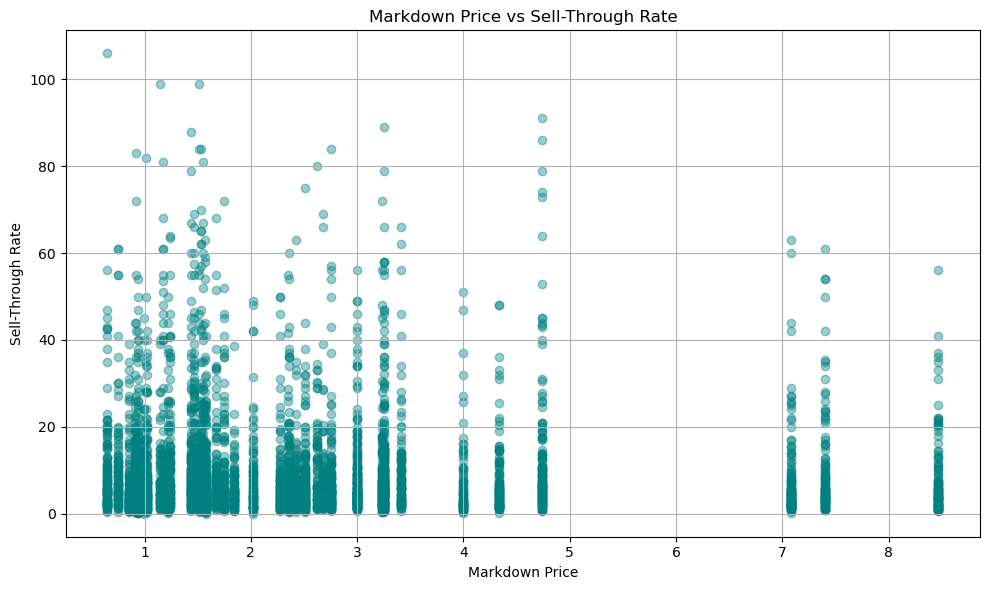

In [ ]:
# Let’s evaluate if lower prices move more inventory:

plt.figure(figsize=(10, 6))
plt.scatter(markdowns['markdown_price'], markdowns['sell_through'], alpha=0.4, color='teal')
plt.title("Markdown Price vs Sell-Through Rate")
plt.xlabel("Markdown Price")
plt.ylabel("Sell-Through Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


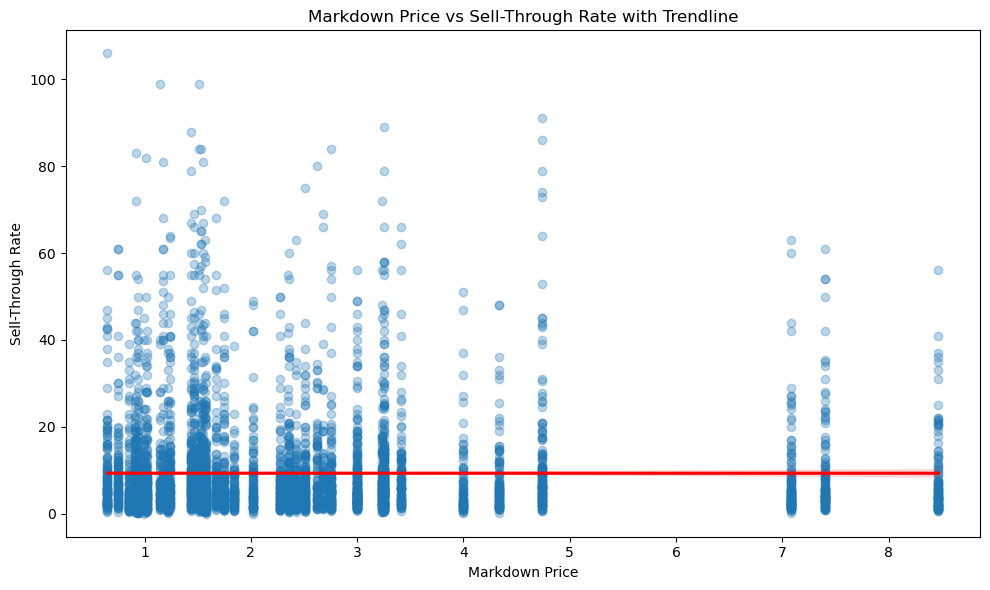

In [ ]:
#Optional: Linear trendline:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(data=markdowns, x='markdown_price', y='sell_through', scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title("Markdown Price vs Sell-Through Rate with Trendline")
plt.xlabel("Markdown Price")
plt.ylabel("Sell-Through Rate")
plt.tight_layout()
plt.show()


## 6. Store-Level Expiry Patterns

Analyzing Store-Level Expiry Patterns is crucial for identifying operational inefficiencies and tailoring interventions at the store level.

* Why it matters: Points to operational factors (e.g., training, cold storage) that drive waste — guides where to target interventions.



### A. Total Units Expired by Store

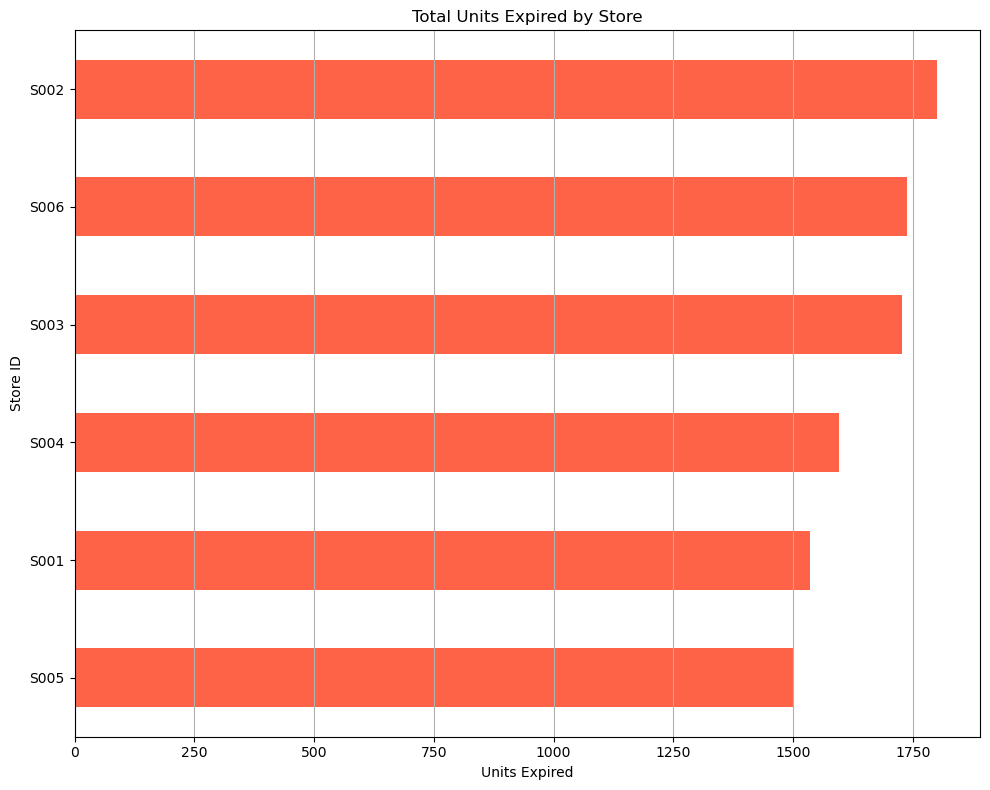

In [5]:
import matplotlib.pyplot as plt

expiry_by_store = inventory.groupby('store_id')['units_expired'].sum().sort_values()
plt.figure(figsize=(10, 8))
expiry_by_store.plot(kind='barh', color='tomato')
plt.title('Total Units Expired by Store')
plt.xlabel('Units Expired')
plt.ylabel('Store ID')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


### 📍 B. Staff Efficiency Score vs. Expiry %


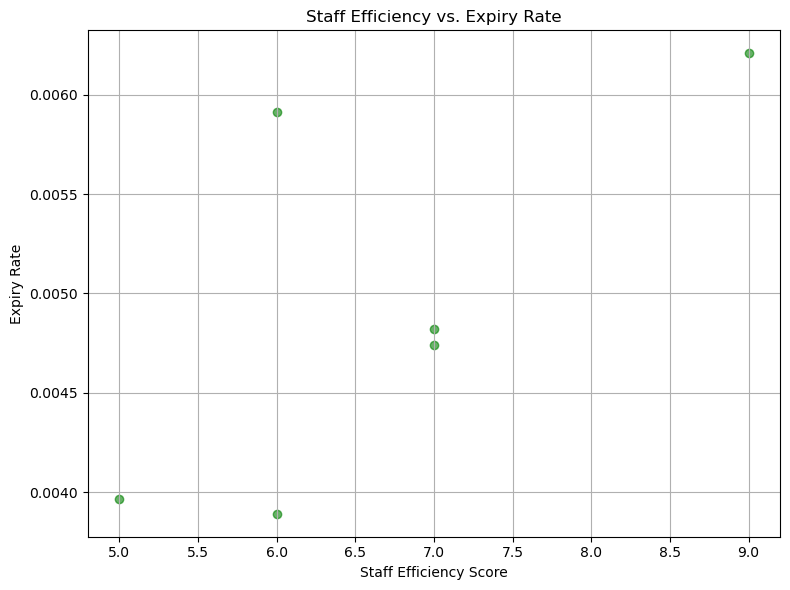

📉 Correlation: Staff Efficiency vs Expiry Rate: 0.69


In [7]:
# Calculate expiry rate per store
store_level = inventory.groupby('store_id').agg({
    'units_sold': 'sum',
    'units_expired': 'sum'
})
store_level['expiry_rate'] = store_level['units_expired'] / (store_level['units_expired'] + store_level['units_sold'])

# Merge with staff efficiency data
# = pd.read_csv("path_to/stores_master.csv")  # Adjust path
merged = store_level.merge(stores[['store_id', 'staff_efficiency_score']], on='store_id')

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(merged['staff_efficiency_score'], merged['expiry_rate'], alpha=0.6, color='green')
plt.title('Staff Efficiency vs. Expiry Rate')
plt.xlabel('Staff Efficiency Score')
plt.ylabel('Expiry Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation
correlation = merged[['staff_efficiency_score', 'expiry_rate']].corr().iloc[0, 1]
print(f"📉 Correlation: Staff Efficiency vs Expiry Rate: {correlation:.2f}")


c:\Users\godwi\Downloads\Anconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


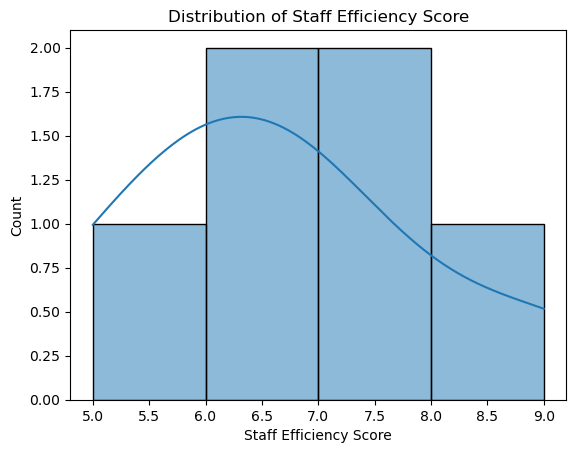

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(stores['staff_efficiency_score'], kde=True)
plt.title('Distribution of Staff Efficiency Score')
plt.xlabel('Staff Efficiency Score')
plt.show()


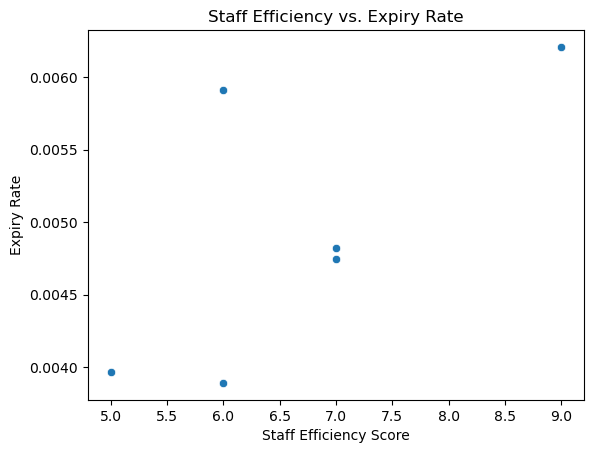

In [9]:
# First, calculate expiry rate per store
store_expiry = inventory.groupby('store_id')[['units_expired', 'units_sold']].sum()
store_expiry['expiry_rate'] = store_expiry['units_expired'] / (store_expiry['units_expired'] + store_expiry['units_sold'])

# Merge with staff efficiency
store_efficiency = stores[['store_id', 'staff_efficiency_score']]
store_expiry = store_expiry.merge(store_efficiency, on='store_id')

# Scatter plot
sns.scatterplot(data=store_expiry, x='staff_efficiency_score', y='expiry_rate')
plt.title('Staff Efficiency vs. Expiry Rate')
plt.xlabel('Staff Efficiency Score')
plt.ylabel('Expiry Rate')
plt.show()


In [12]:
# Add refrigeration capacity if available
store_expiry = store_expiry.merge(stores[['store_id', 'refrigeration_capacity']], on='store_id', how='left')

correlation_matrix = store_expiry[['expiry_rate', 'staff_efficiency_score', 'refrigeration_capacity']].corr()


In [13]:
correlation_matrix


,expiry_rate,staff_efficiency_score,refrigeration_capacity
expiry_rate,1.000000,0.687133,-0.055250
staff_efficiency_score,0.687133,1.000000,-0.267261
refrigeration_capacity,-0.055250,-0.267261,1.000000


##  7. High-Risk Products
This: 

* Groups the inventory by product_id.
* Aggregates total expired and sold units.
* Computes each product’s expiry rate.
* Sorts from most at-risk to least.

* Why it matters: Helps prioritize products for better forecasting, earlier markdowns, or alternative sourcing.

In [17]:
risky_products = (
    inventory.groupby('product_id')
    .agg({'units_expired': 'sum', 'units_sold': 'sum'})
    .assign(expiry_rate=lambda df: df['units_expired'] / (df['units_expired'] + df['units_sold']))
    .sort_values('expiry_rate', ascending=False)
)
risky_products = risky_products.merge(products[['product_id', 'product_name', 'category']], on='product_id')


In [18]:
risky_products


,product_id,units_expired,units_sold,expiry_rate,product_name,category
0,P029,213,28391,0.007447,Äpfel Elstar,Frischware
1,P014,228,30449,0.007432,Körnerbrötchen,Backwaren
2,P034,310,42284,0.007278,Rinderhackfleisch,Fleisch
3,P045,215,31430,0.006794,Antipasti Gemüse,Feinkost
4,P025,180,27010,0.006620,Erdbeeren,Frischware
5,P008,205,31023,0.006565,Frischkäse,Molkereiprodukte
6,P031,308,46934,0.006520,Erdbeeren,Frischware
7,P017,228,38238,0.005927,Schwarzbrot,Backwaren
8,P010,274,46661,0.005838,Schwarzbrot,Backwaren
9,P042,237,40789,0.005777,Kartoffelsalat,Feinkost


In [22]:
top_risky_products = risky_products[(risky_products['units_expired'] + risky_products['units_sold']) > 50]


In [23]:
top_risky_products

,product_id,units_expired,units_sold,expiry_rate,product_name,category
0,P029,213,28391,0.007447,Äpfel Elstar,Frischware
1,P014,228,30449,0.007432,Körnerbrötchen,Backwaren
2,P034,310,42284,0.007278,Rinderhackfleisch,Fleisch
3,P045,215,31430,0.006794,Antipasti Gemüse,Feinkost
4,P025,180,27010,0.006620,Erdbeeren,Frischware
5,P008,205,31023,0.006565,Frischkäse,Molkereiprodukte
6,P031,308,46934,0.006520,Erdbeeren,Frischware
7,P017,228,38238,0.005927,Schwarzbrot,Backwaren
8,P010,274,46661,0.005838,Schwarzbrot,Backwaren
9,P042,237,40789,0.005777,Kartoffelsalat,Feinkost


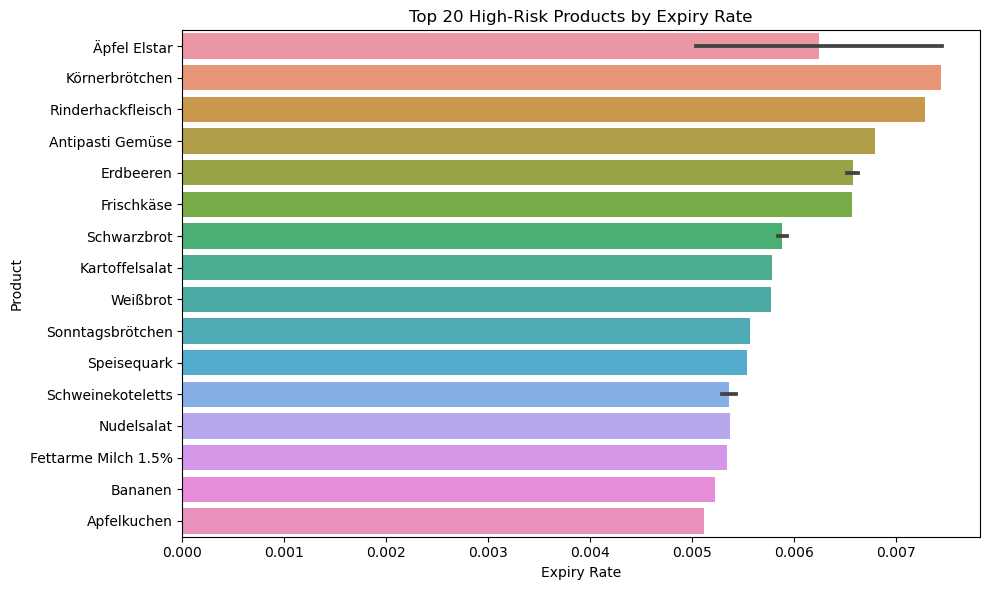

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

top_risky = risky_products.head(20)
plt.figure(figsize=(10, 6))
sns.barplot(y='product_name', x='expiry_rate', data=top_risky)
plt.title("Top 20 High-Risk Products by Expiry Rate")
plt.xlabel("Expiry Rate")
plt.ylabel("Product")
plt.tight_layout()
plt.show()


In [25]:
category_risk = risky_products.groupby('category').agg({
    'units_expired': 'sum',
    'units_sold': 'sum'
}).assign(expiry_rate=lambda df: df['units_expired'] / (df['units_expired'] + df['units_sold'])).sort_values('expiry_rate', ascending=False)


In [26]:
category_risk

,units_expired,units_sold,expiry_rate
category,,,
Feinkost,1525,297946,0.005092
Backwaren,2487,488407,0.005066
Fleisch,1703,353658,0.004792
Frischware,2558,564318,0.004512
Molkereiprodukte,1624,364516,0.004435


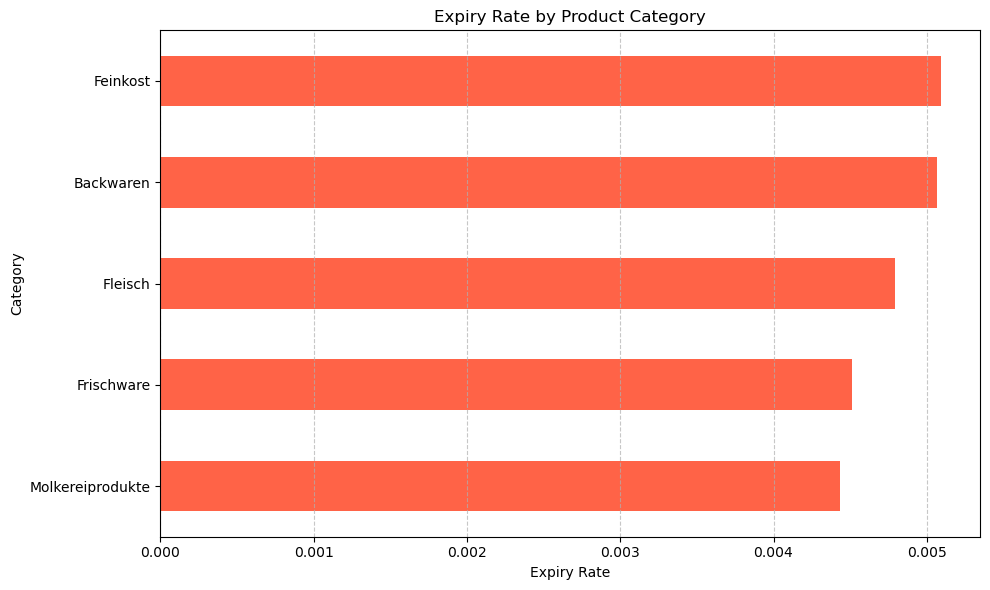

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
category_risk['expiry_rate'].plot(kind='barh', color='tomato')
plt.title("Expiry Rate by Product Category")
plt.xlabel("Expiry Rate")
plt.ylabel("Category")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
